In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d
import mpi4py

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
sic = pc.BathCell(3.073, 3.073, 10.053, 90, 90, 120, 'deg')
# z axis in cell coordinates
sic.zdir = [0, 0, 1]
# Next, user has to define positions of atoms in the unit cell. It is done with BathCell.add_atoms function. It takes an unlimited number of arguments, each argument is a tuple. First element of the tuple is the name of the atom, second - list of xyz coordinates either in cell units (if keyword type='cell', default value) or in Angstrom (if keyword type='angstrom'). Returns BathCell.atoms dictionary, which contains list of coordinates for each type of elements.
# position of atoms
sic.add_atoms(('Si', [0.00000000, 0.00000000, 0.1880]),
              ('Si', [0.00000000, 0.00000000, 0.6880]),
              ('Si', [0.33333333, 0.66666667, 0.4380]),
              ('Si', [0.66666667, 0.33333333, 0.9380]),
              ('C', [0.00000000, 0.00000000, 0.0000]),
              ('C', [0.00000000, 0.00000000, 0.5000]),
              ('C', [0.33333333, 0.66666667, 0.2500]),
              ('C', [0.66666667, 0.33333333, 0.7500]))

# isotopes
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))

# defect position in cell units
vsi_cell = [0, 0, 0.1880]
vc_cell = [0, 0, 0]

# Generate bath spin positions
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

# Prepare rotation matrix to align with z axis of generated atoms
# This matrix, acting on the [0, 0, 1] in Cartesian coordinates of the GIPAW output,
# Should produce [a, b, c] vector, aligned with the z-direction of the BathCell
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = [0.6, 0.5, 0.5]
# Read GIPAW results
exatoms = pc.read_qe('axial/pw.in',
                     hyperfine='axial/gipaw.out',
                     center=center, rotation_matrix=M,
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})

position = sic.to_cartesian(vsi_cell)
##########################################################################################
# Now basal stuff
##########################################################################################

# Coordinates of vacancies in cell coordinates (note that Vsi is not located in the first unit cell)
vsi_cell = -np.array([1 / 3, 2 / 3, 0.0620])
vc_cell = np.array([0, 0, 0])

sic.zdir = [0, 0, 1]

# Rotation matrix for DFT supercell
R = pc.rotmatrix([0, 0, 1], sic.to_cartesian(vsi_cell - vc_cell))

sic.zdir = vsi_cell - vc_cell ### ????

# Generate bath spin positions
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)],
                          seed=seed)

M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Position of (0,0,0) point in cell coordinates
center = np.array([0.59401, 0.50000, 0.50000])

# Read GIPAW results
exatoms = pc.read_qe('basal/pw.in',
                     hyperfine='basal/gipaw.out',
                     center=center, rotation_matrix=(M.T @ R),
                     rm_style='col',
                     isotopes={'C':'13C', 'Si':'29Si'})


# isotopes
sic.add_isotopes(('29Si', 1), ('13C', 1))
allcell = sic.gen_supercell(50, remove=[('Si', vsi_cell),
                                        ('C', vc_cell)],
                            seed=seed)

indexes, ext_indexes = pc.same_bath_indexes(allcell, exatoms, 0.2, True)
print(f"There are {indexes.size} same elements."
      f" Size of the DFT supercell is {exatoms.size}")

# ---OUTPUT---
# There are 1438 same elements. Size of the DFT supercell is 1438




# # Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
# atoms['14C'].gyro = 0
# atoms['14C'].spin = 0

# Setting up the Simulator

# Setting up CCE calculations

order = 2
r_bath = 30
r_dipole = 8
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]


There are 1438 same elements. Size of the DFT supercell is 1438


In [4]:
# print('Cell\n', diamond.cell)
# print('\nAtoms\n', diamond.atoms)

In [5]:
##########################################################################################
# ZFS Parametters of NV center in diamond
#############################################
# ZFS D parameter
start = 1.334 * 1e3
stop = 1.334 * 1e8
# start = 1e-20
# stop = 1e-19
num = 4

D_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz

D_list = [1.334 * (10**(4+i)) for i in range(0,num)]

# D_list = np.linspace(start, stop, num=num)

# D_list = [1] # Note for later, very low values of D give remarkably high coherence??

# D_list = [19390]
print("D_list: ", D_list)
#############################################
# ZFS E parameter
E_start = 1
E_stop =( 1.8e3 ) /3
E_num = 4
E_list = np.logspace(np.log10(E_start), np.log10(E_stop), num=E_num) 
# E_list = np.linspace(E_start, E_stop, num=E_num)
E_list = [i*0.0138 for i in D_list]
# E = 0.0184 * 1e6 VV in SiC

# E_list = [139.24798] # Note for later, this value of E give remarkably high coherence??

##########################################################################################
### Other parameters
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
            ('13C',  1 / 2,  6.72828),
            ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Time points
time_space = np.linspace(0, 1, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 0

##########################################################################################
# Mag. Field (Bx By Bz)
b = np.array([0,0, 500])  # in G
##########################################################################################
B = 0
N = 0

coherence_list = []
coherence_dict = {}

D_list:  [13340.0, 133400.0, 1334000.0, 13340000.0]


In [6]:
for idx, D in enumerate(D_list):
    print(str(1+idx) + "/" + str(len(D_list)))
    for E in E_list:
        # Define the central spin
        # nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

        # print(nv)

        # Setting the Simulator object
        ### Setting the runner engine
        calc = pc.Simulator(1, position, bath=atoms, external_bath=exatoms,
                            D=D, E=E, pulses=N, alpha=0, beta=1,
                            r_bath=r_bath, r_dipole=r_dipole)
        # # Function Simulator.read_bath can be called explicitly to initialize the spin bath. The additional keyword argument external_bath takes an instance of BathArray with hyperfine couplings read from Quantum Espresso. The program then identifies the spins with the same name at the same positions (within the range defined by the error_range keyword argument) in the total bath and sets their hyperfine couplings.
        # # Finally, we call Simulator.generate_clusters to identify the bath spin clusters in the provided bath.
        # calc.read_bath(atoms, r_bath, external_bath=exatoms)
        # calc.generate_clusters(order, r_dipole=r_dipole)

        calc.center.generate_states()
        calc.generate_clusters(order)

        # print(calc)
        # Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
        # nspin = calc.bath
        # # Set model quadrupole tensor at N atom
        # quad = np.asarray([[-2.5, 0, 0],
        #                    [0, -2.5, 0],
        #                    [0, 0,  5.0]]) * 1e3 * 2 * np.pi

        # nspin['Q'][nspin['N'] == '14N'] = quad
        # print(calc)

        # Hahn-echo pulse sequence
        # pulse_sequence = [pc.Pulse('x',np.pi)]
        # pulse_sequence += [pc.Pulse('z',np.pi)]
        # pulse_sequence += [pc.Pulse('y',np.pi)]


        # Calculate coherence function
        l_generatilze = calc.compute(time_space, nbstates=20, seed=seed,
                        method='gcce',
                        quantity='coherence', as_delay=False,
                        parallel=True,)
        
        # At the end of your inner loop:
        key = (D, E)
        coherence_dict[key] = np.abs(l_generatilze)

1/4


/Users/markoneill/Desktop/Physics/SS/Capstone/VScode Capstone Folder/Capstone_environment/lib/python3.10/site-packages/numpy/ma/core.py:467: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


2/4
3/4
4/4


In [12]:
print(coherence_dict.keys())

dict_keys([(13340.0, 184.09199999999998), (13340.0, 1840.92), (13340.0, 18409.2), (13340.0, 184092.0), (133400.0, 184.09199999999998), (133400.0, 1840.92), (133400.0, 18409.2), (133400.0, 184092.0), (1334000.0, 184.09199999999998), (1334000.0, 1840.92), (1334000.0, 18409.2), (1334000.0, 184092.0), (13340000.0, 184.09199999999998), (13340000.0, 1840.92), (13340000.0, 18409.2), (13340000.0, 184092.0)])


In [13]:
# mock = calc

# # add 3D axis
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(projection='3d')

# # We want to visualize the smaller bath
# data = mock.bath

# # First plot the positions of the bath
# colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
# ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# # Plot all pairs of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 2
# # for c in mock.clusters[2]:
# #     ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# # Plot all triplets of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 3
# for c in mock.clusters[3]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

# ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

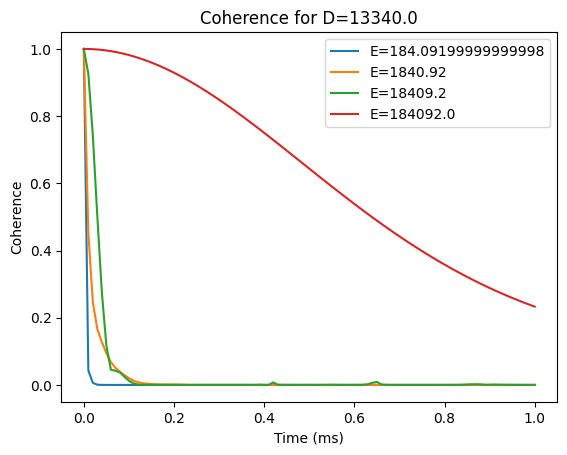

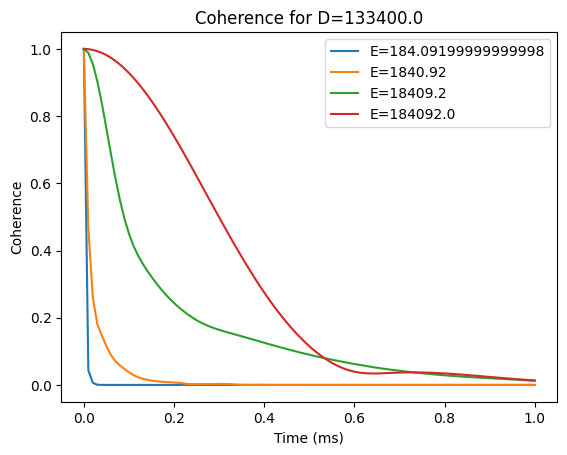

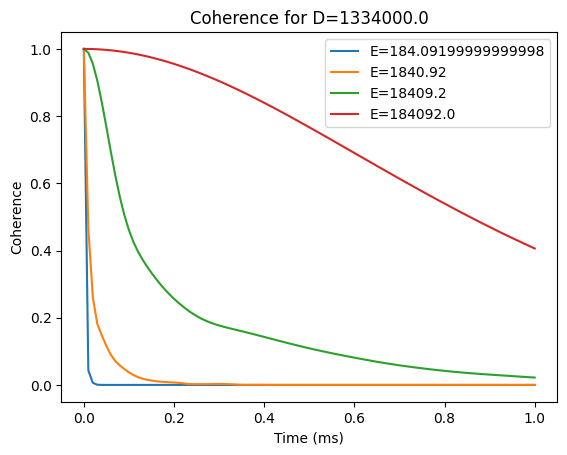

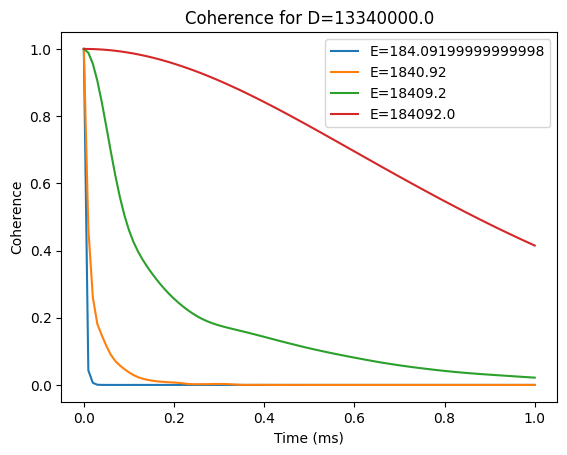

In [14]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Iterate over each unique D value
for D in unique_D_values:
    # plt.figure(figsize=(10,7))
    for E in unique_E_values:
        coherence_for_DE = coherence_dict[(D, E)]
        plt.plot(time_space, coherence_for_DE, label=f'E={E}')
    
    # plt.ylim(0,1)
    plt.title(f'Coherence for D={D}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Coherence')
    plt.legend()
    plt.show()

In [15]:
# def coherence_time_func(time, beta, T2):
#     return np.exp(-(time / T2) ** beta)

# from scipy.optimize import curve_fit

# # Choose a reference E value (smallest E in this case)
# ref_E_value = min(unique_E_values)

# # Continue as before
# T2_values = {}
# beta_values = {}

# rows = 4
# cols = 5
# fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
# axes = axes.ravel()

# for idx, D in enumerate(unique_D_values):
#     # Extract coherence data for the given D and reference E value
#     coherence_data = coherence_dict[(D, ref_E_value)]

#     try:
#         popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
#         beta_fitted, T2_fitted = popt
#         beta_values[D] = beta_fitted
#         T2_values[D] = T2_fitted

#         ax = axes[idx]
#         ax.plot(time_space, coherence_data, 'b-', label='Simulated Data')
#         ax.plot(time_space, coherence_time_func(time_space, *popt), 'r--', label=f'Fit: β={beta_fitted:.4f}, T2={T2_fitted:.4f} ms')
#         ax.set_title(f'D={D} kHz')
#         ax.set_xlabel('Time (ms)')
#         ax.set_ylabel('Coherence')
#         ax.legend()

#     except Exception as e:
#         print(f"Error fitting for D = {D} kHz: {e}")
#         beta_values[D] = None
#         T2_values[D] = None

# plt.tight_layout()
# plt.show()

# # for D, T2 in T2_values.items():
# #     print(f"D = {D} kHz: T2 = {T2:.4f} ms")


/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_8687/2313418927.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(time / T2) ** beta)
/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_8687/2313418927.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(time / T2) ** beta)


Error fitting for D = 13340.0 kHz, E = 18409.2: Optimal parameters not found: Number of calls to function has reached maxfev = 600.


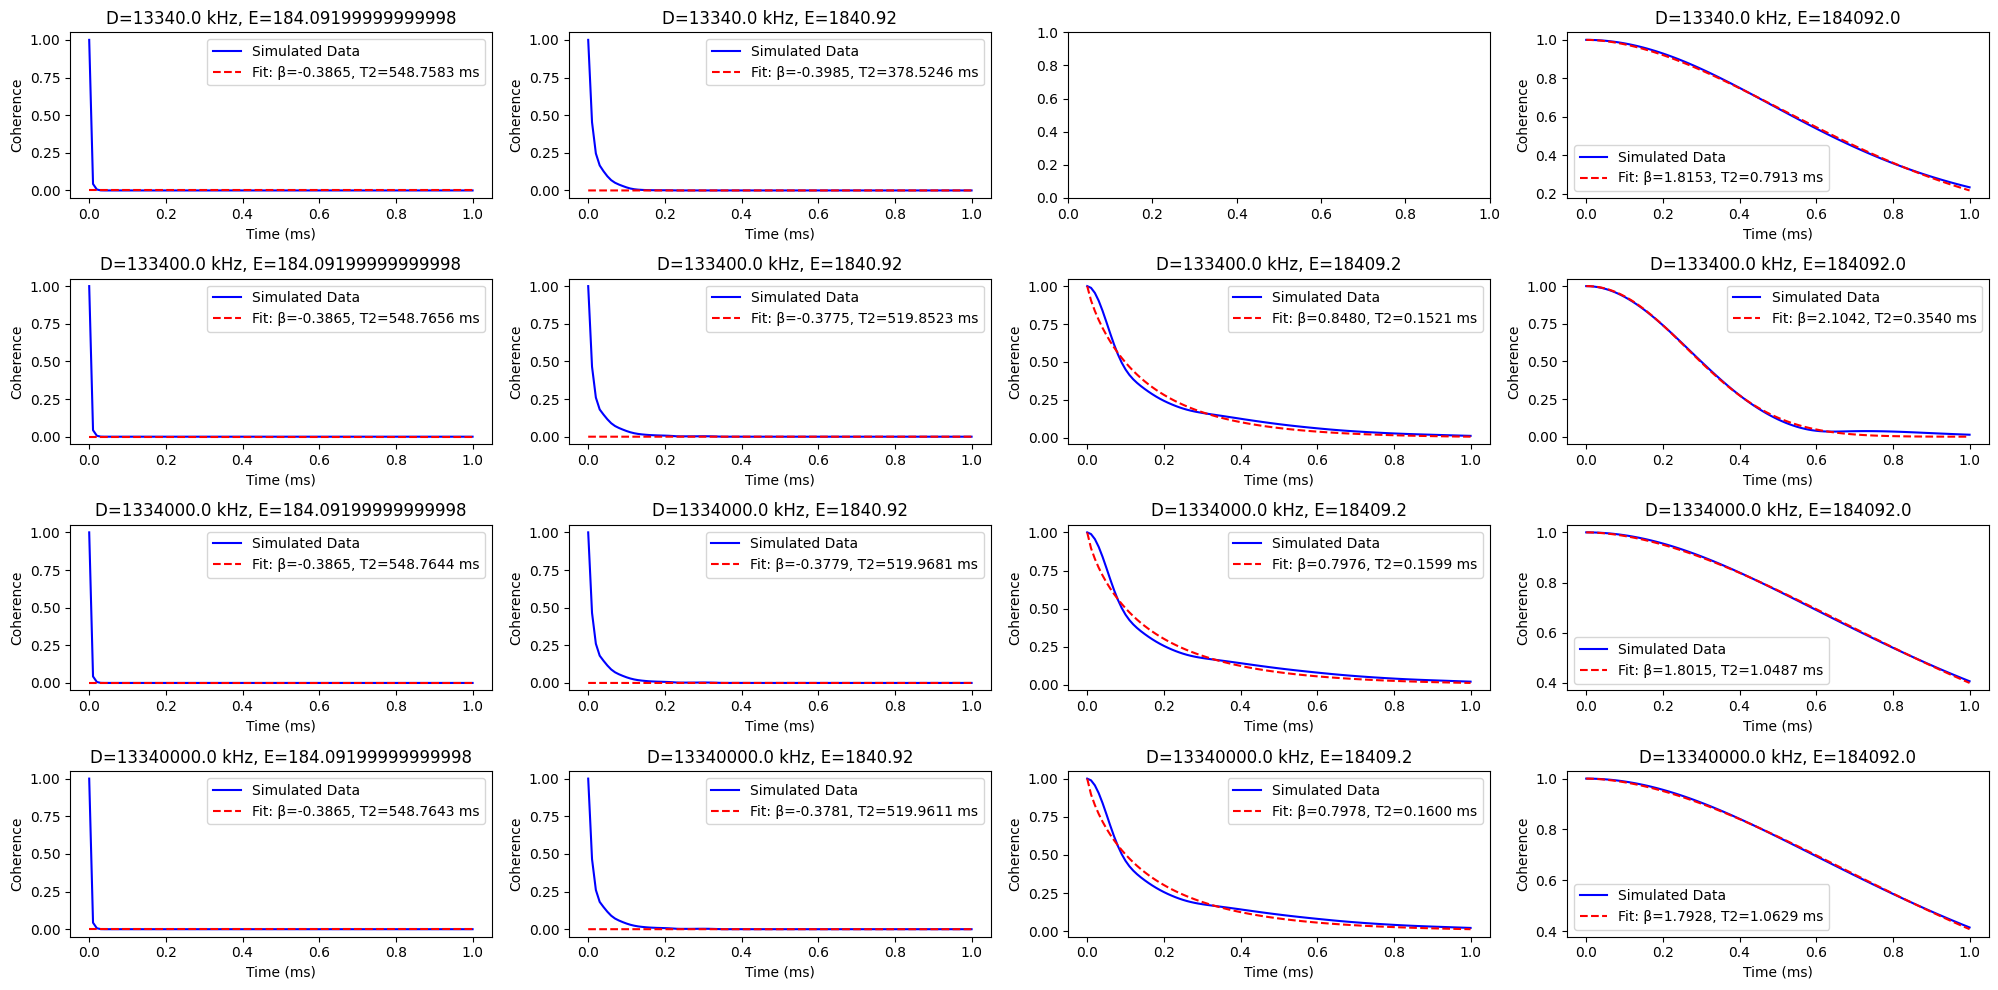

D = 13340.0 kHz, E = 184.09199999999998: T2 = 548.7583 ms
D = 13340.0 kHz, E = 1840.92: T2 = 378.5246 ms


TypeError: unsupported format string passed to NoneType.__format__

In [16]:
def coherence_time_func(time, beta, T2):
    return np.exp(-(time / T2) ** beta)

from scipy.optimize import curve_fit

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

T2_values = {}
beta_values = {}

rows = len(unique_D_values)
cols = len(unique_E_values)
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

for i, D in enumerate(unique_D_values):
    for j, E in enumerate(unique_E_values):
        # Extract coherence data for the given D and E value
        coherence_data = coherence_dict[(D, E)]
        
        try:
            popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
            beta_fitted, T2_fitted = popt
            beta_values[(D, E)] = beta_fitted
            T2_values[(D, E)] = T2_fitted

            ax = axes[i, j]
            ax.plot(time_space, coherence_data, 'b-', label='Simulated Data')
            ax.plot(time_space, coherence_time_func(time_space, *popt), 'r--', label=f'Fit: β={beta_fitted:.4f}, T2={T2_fitted:.4f} ms')
            ax.set_title(f'D={D} kHz, E={E}')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Coherence')
            ax.legend()

        except Exception as e:
            print(f"Error fitting for D = {D} kHz, E = {E}: {e}")
            beta_values[(D, E)] = None
            T2_values[(D, E)] = None

plt.tight_layout()
plt.show()

for (D, E), T2 in T2_values.items():
    print(f"D = {D} kHz, E = {E}: T2 = {T2:.4f} ms")


In [ ]:
print(coherence_dict.values())

dict_values([masked_array(data=[1.0000000000000135, 0.2389455408353919,
                   0.06796058404393528, 0.04915365634885661,
                   0.018905983975215868, 0.02417182110921027,
                   0.009697418486793162, 0.057284306410913075,
                   0.015166770859264085, 0.028202830682754376,
                   0.028038116547305356, 0.018223547329939926,
                   0.0076677932155175405, 0.0020351729264869527,
                   0.0015507926424222231, 0.001044404535228279,
                   0.001625287857501267, 0.009159632271023604,
                   0.019098475339141607, 0.0012217158636024918,
                   0.00013292919679738397, 6.274589733747498e-05,
                   5.317452982505097e-05, 0.000645125463251285,
                   0.003303042401248002, 4.396840668921028e-07,
                   2.8648400657181027e-07, 2.291838514799103e-06,
                   1.0256381726975296e-05, 3.2208949799344345e-06,
                   0.000315894222

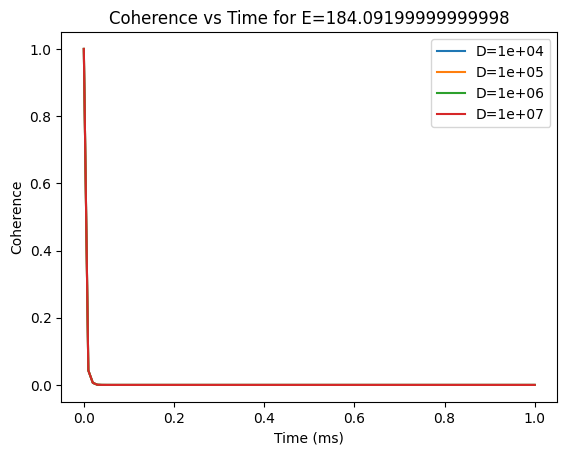

In [17]:
# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_for_smallest_E = [coherence_dict[(D, smallest_E)] for D in unique_D_values]

plt.figure()
for i, D_val in enumerate(unique_D_values):
    plt.plot(time_space, coherence_for_smallest_E[i], label=f'D={D_val:.0e}')
    
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
plt.legend()
plt.title(f'Coherence vs Time for E={smallest_E}')
# plt.ylim(0,10)
plt.show()


In [18]:
# # Extract unique D values
# unique_D_values = sorted(coherence_dict.keys())

# # Extract coherence values for the smallest D value
# smallest_D = min(unique_D_values)
# coherence_for_smallest_D = [coherence_dict[D] for D in unique_D_values]

# plt.figure()
# for i, D_val in enumerate(unique_D_values):
#     plt.plot(time_space, coherence_for_smallest_D[i], label=f'D={D_val:.0e}')
    
# plt.xlabel('Time (ms)')
# plt.ylabel('Coherence')
# plt.legend()
# plt.title(f'Coherence vs Time for D={smallest_D}')
# plt.show()


In [19]:
# # Visualize difference in coherence for different E values

# # Extract unique D and E values
# unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
# unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))


# # Reference coherence for smallest E
# ref_E_value = min(E_list)

# # Iterate over each unique D value
# for D in unique_D_values:
#     # The reference coherence changes for each D. Update the ref_coherence for each D.
#     ref_coherence = coherence_dict[(D, ref_E_value)]

#     # plt.figure(figsize=(10,7))
#     for E in unique_E_values:
#         if E == ref_E_value:  # Don't plot the difference for the reference E
#             continue
#         coherence_for_DE = coherence_dict[(D, E)]
        
#         # Plot the difference
#         difference = coherence_for_DE - ref_coherence
#         plt.plot(time_space, difference, label=f'ΔE={E}')
    
#     plt.title(f'Coherence Difference from E={ref_E_value} for D={D}')
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Difference in Coherence')
#     plt.legend()
#     plt.show()


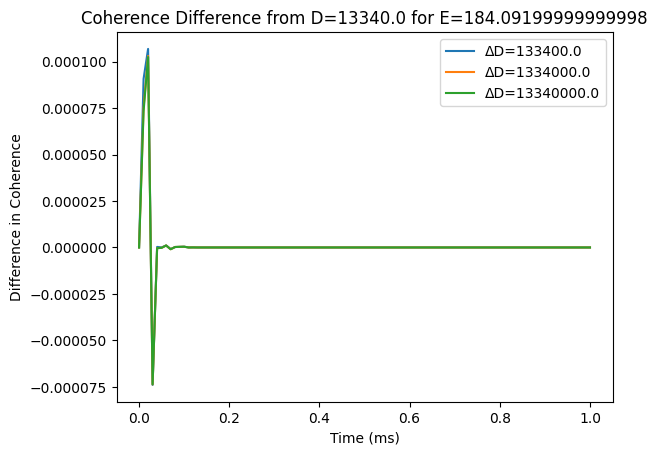

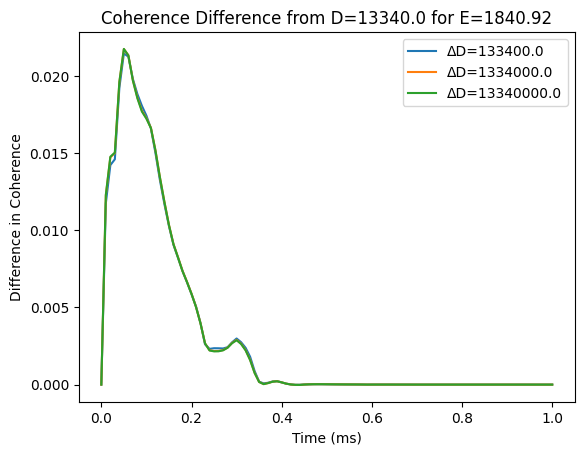

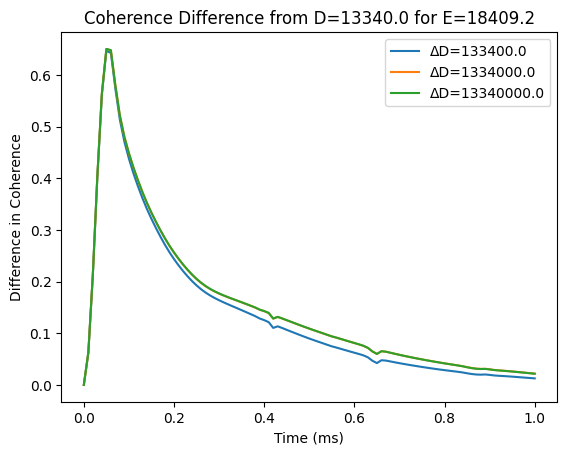

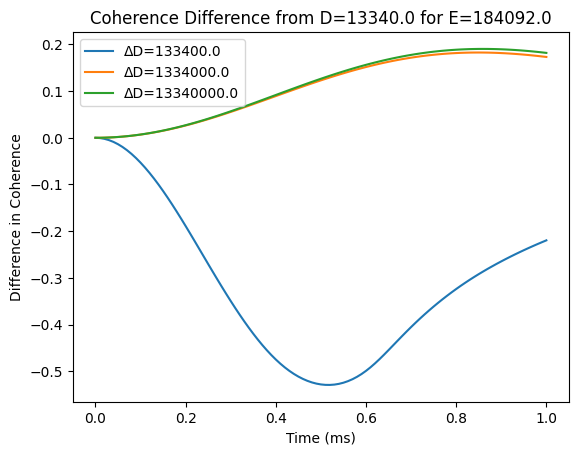

In [20]:
# Visualize difference in coherence for different D values

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest D
ref_D_value = min(unique_D_values)

# Iterate over each unique E value
for E in unique_E_values:
    # The reference coherence changes for each E. Update the ref_coherence for each E.
    ref_coherence = coherence_dict[(ref_D_value, E)]

    # plt.figure(figsize=(10,7))
    for D in unique_D_values:
        if D == ref_D_value:  # Don't plot the difference for the reference D
            continue
        coherence_for_DE = coherence_dict[(D, E)]
        
        # Plot the difference
        difference = coherence_for_DE - ref_coherence
        plt.plot(time_space, difference, label=f'ΔD={D}')
    
    plt.title(f'Coherence Difference from D={ref_D_value} for E={E}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Difference in Coherence')
    plt.legend()
    plt.show()


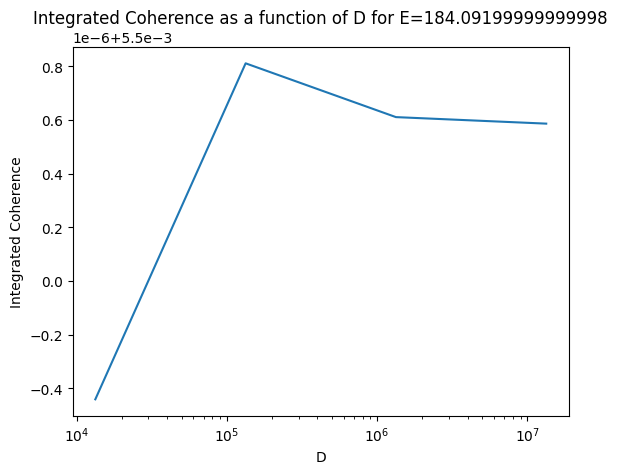

In [23]:
def integrate(x_list, y_list):
    """
    Integrate a list of y values with respect to a list of x values.
    """
    return np.trapz(y_list, x_list)

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest E
ref_E_value = min(E_list)

# Integrate each coherence curve for each D at the reference E value
integrated_coherence = [integrate(time_space, coherence_dict[(D, ref_E_value)]) for D in unique_D_values]

# Plot the integrated coherence as a function of D
plt.figure()
plt.semilogx(unique_D_values, integrated_coherence)
plt.xlabel('D')
plt.ylabel('Integrated Coherence')
plt.title(f'Integrated Coherence as a function of D for E={ref_E_value}')
plt.show()


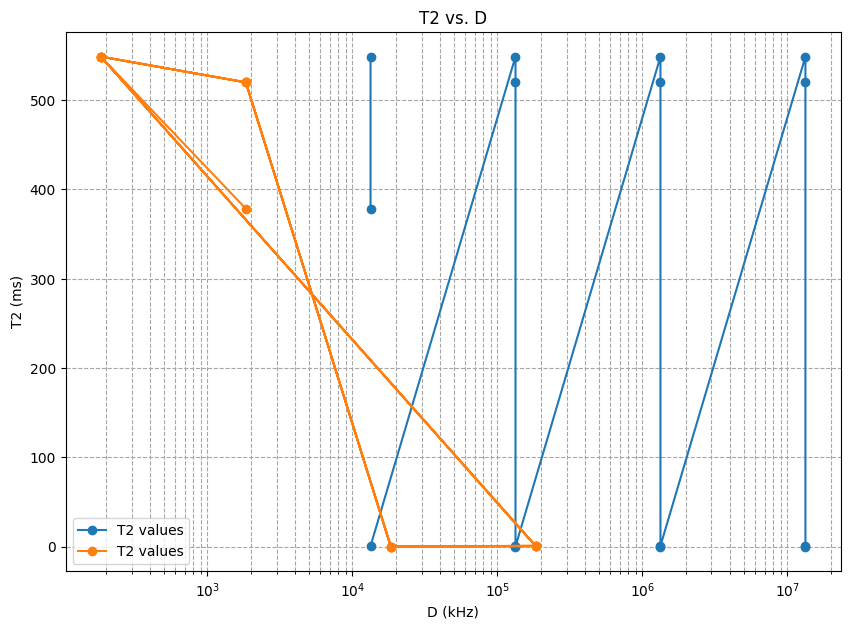

In [22]:
# Extract D values and corresponding T2 values
D_values = list(T2_values.keys())
T2_list = list(T2_values.values())

# Plot T2 vs D
plt.figure(figsize=(10,7))
plt.semilogx(D_values, T2_list, 'o-', label='T2 values')  # Using a log-scale for the x-axis if D_values is on a logarithmic scale
plt.title('T2 vs. D')
plt.xlabel('D (kHz)')
plt.ylabel('T2 (ms)')
plt.grid(True, which="both", ls="--", c='0.65')
# plt.ylim(0,100)
plt.legend()
plt.show()


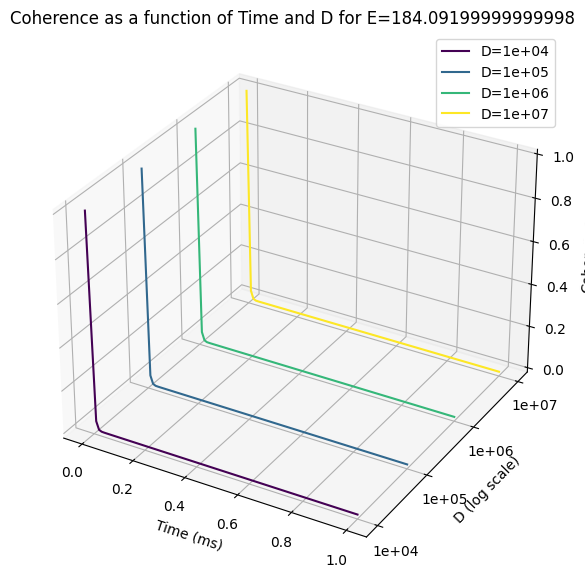

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


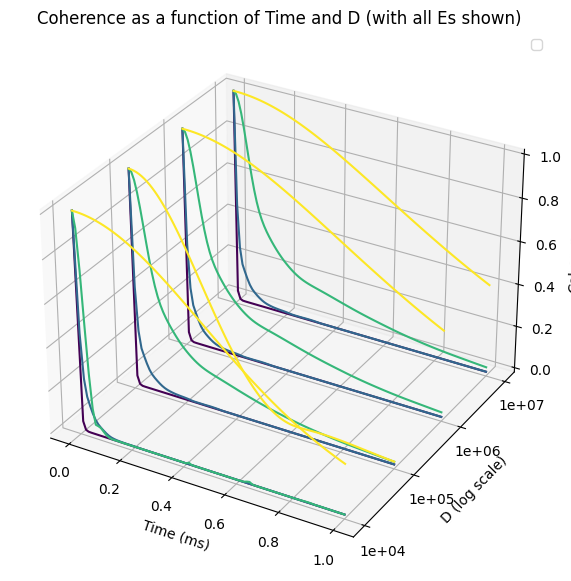

In [24]:
# 3d plot of coherence as a function of D and E (only showing plots for smallest E value)
# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_matrix_for_smallest_E = np.array([coherence_dict[(D, smallest_E)] for D in unique_D_values])

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting coherence for each D value at the smallest E
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_D_values)))
for i, D_val in enumerate(unique_D_values):
    ax.plot(TIME[i], np.log10([D_val] * len(TIME[i])), coherence_matrix_for_smallest_E[i], color=colors[i], label=f'D={D_val:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title(f'Coherence as a function of Time and D for E={smallest_E}')
ax.legend()

plt.show()








##########################################################################################
# For all E values, plot coherence as a function of D and time

# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for each (D, E) pair and store them as a list of 2D arrays
coherence_matrices = [np.array([coherence_dict[(D, E)] for D in unique_D_values]) for E in unique_E_values]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each E value as a collection of lines (one for each D)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_E_values)))
for i, E in enumerate(unique_E_values):
    for j, D_val in enumerate(unique_D_values):
        ax.plot(TIME[j], np.log10([D_val] * len(TIME[j])), coherence_matrices[i][j], color=colors[i] )#, label=f'E={E}' if j == 0 else "")

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D (with all Es shown)')
ax.legend()

plt.show()




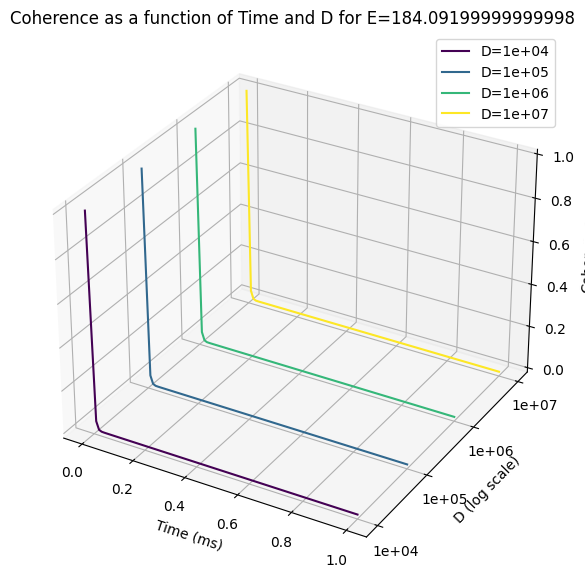

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


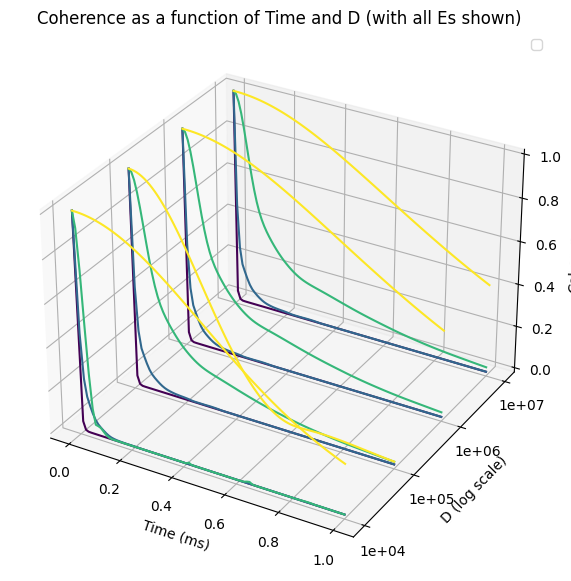

In [25]:
# 3d plot of coherence as a function of D and E (only showing plots for smallest E value)
# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_matrix_for_smallest_E = np.array([coherence_dict[(D, smallest_E)] for D in unique_D_values])

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting coherence for each D value at the smallest E
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_D_values)))
for i, D_val in enumerate(unique_D_values):
    ax.plot(TIME[i], np.log10([D_val] * len(TIME[i])), coherence_matrix_for_smallest_E[i], color=colors[i], label=f'D={D_val:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title(f'Coherence as a function of Time and D for E={smallest_E}')
ax.legend()

plt.show()








##########################################################################################
# For all E values, plot coherence as a function of D and time

# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for each (D, E) pair and store them as a list of 2D arrays
coherence_matrices = [np.array([coherence_dict[(D, E)] for D in unique_D_values]) for E in unique_E_values]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each E value as a collection of lines (one for each D)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_E_values)))
for i, E in enumerate(unique_E_values):
    for j, D_val in enumerate(unique_D_values):
        ax.plot(TIME[j], np.log10([D_val] * len(TIME[j])), coherence_matrices[i][j], color=colors[i] )#, label=f'E={E}' if j == 0 else "")

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D (with all Es shown)')
ax.legend()

plt.show()




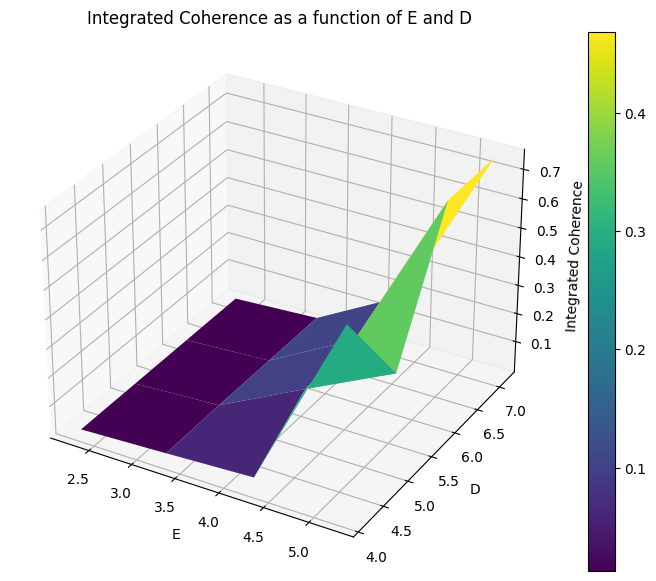

In [54]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Create meshgrid for E and D
E, D = np.meshgrid(unique_E_values, unique_D_values)

# Transform values to logarithmic scale
log_unique_D_values = np.log10(unique_D_values)
log_unique_E_values = np.log10(unique_E_values)

# Create meshgrid for log(E) and log(D)
logE, logD = np.meshgrid(log_unique_E_values, log_unique_D_values)

# Calculate integrated coherence for each E, D pair
Z = np.array([[integrate(time_space, coherence_dict[(d, e)]) for e in unique_E_values] for d in unique_D_values])

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(logE, logD, Z, cmap='viridis')
fig.colorbar(surf)

ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('Integrated Coherence')
ax.set_title('Integrated Coherence as a function of E and D')
# ax.view_init(elev=35, azim=135)

plt.show()


In [27]:
print(unique_D_values)

[13340.0, 133400.0, 1334000.0, 13340000.0]


/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_8687/1889039758.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(time / T2) ** beta)
/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_8687/1889039758.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(time / T2) ** beta)


Error fitting for D = 13340.0 kHz, E = Optimal parameters not found: Number of calls to function has reached maxfev = 600.: Optimal parameters not found: Number of calls to function has reached maxfev = 600.


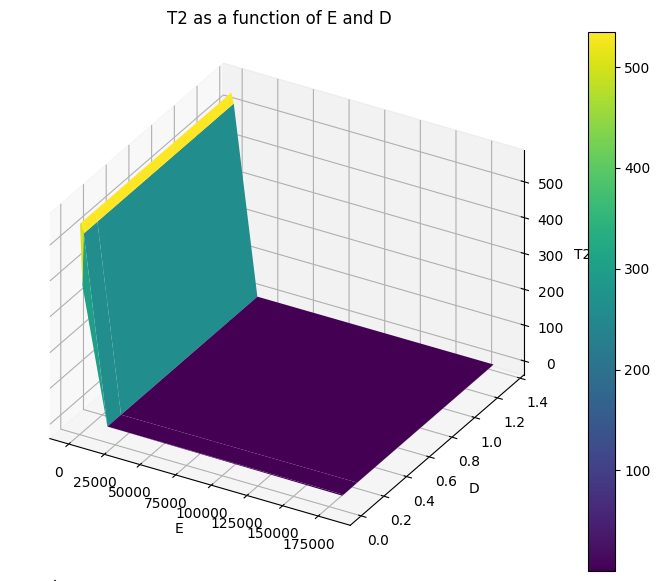

In [33]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Create meshgrid for E and D
E, D = np.meshgrid(unique_E_values, unique_D_values)

# Calculate T2 for each E, D pair
Z = np.empty(E.shape)  # create an empty array with the same shape as E and D

for i, d in enumerate(unique_D_values):
    for j, e in enumerate(unique_E_values):
        coherence_data = coherence_dict[(d, e)]
        
        try:
            popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
            _, T2_fitted = popt
            Z[i, j] = T2_fitted
        except Exception as e:
            print(f"Error fitting for D = {d} kHz, E = {e}: {e}")
            Z[i, j] = np.nan  # set to NaN for any error

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

surf = ax.plot_surface(E, D, Z, cmap='viridis')
fig.colorbar(surf)

ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('T2')
ax.set_title('T2 as a function of E and D')
# ax.set_zlim(0,1000000)


plt.show()


/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_8687/1889039758.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(time / T2) ** beta)
/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_8687/1889039758.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(time / T2) ** beta)


Error fitting for D = 13340.0 kHz, E = 18409.2: Optimal parameters not found: Number of calls to function has reached maxfev = 600.


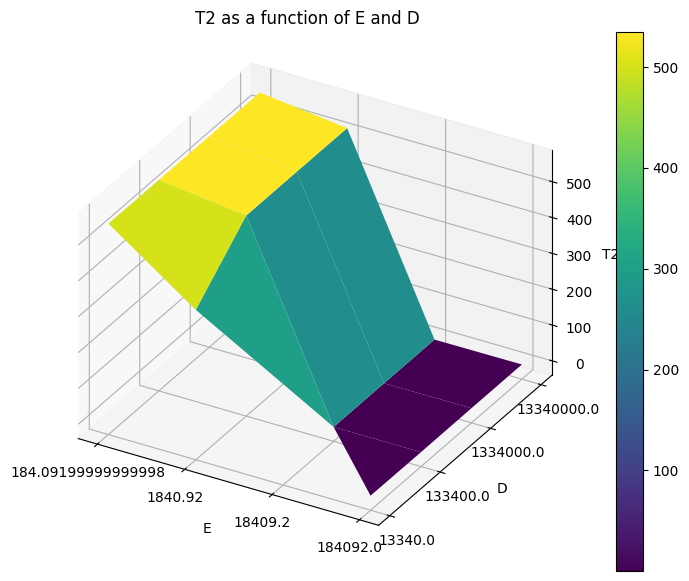

In [53]:
import numpy as np

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Transform values to logarithmic scale
log_unique_D_values = np.log10(unique_D_values)
log_unique_E_values = np.log10(unique_E_values)

# Create meshgrid for log(E) and log(D)
logE, logD = np.meshgrid(log_unique_E_values, log_unique_D_values)

Z = np.empty(logE.shape)  # create an empty array with the same shape as logE and logD

for i, d in enumerate(unique_D_values):
    for j, e in enumerate(unique_E_values):
        coherence_data = coherence_dict[(d, e)]
        
        try:
            popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
            _, T2_fitted = popt
            Z[i, j] = T2_fitted
        except Exception as ex:
            print(f"Error fitting for D = {d} kHz, E = {e}: {ex}")
            Z[i, j] = np.nan  # set to NaN for any error

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

surf = ax.plot_surface(logE, logD, Z, cmap='viridis')
fig.colorbar(surf)

# Set axis labels
ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('T2')
ax.set_title('T2 as a function of E and D')

# Manually set ticks and tick labels to reflect original scale
ax.set_xticks(log_unique_E_values)
ax.set_yticks(log_unique_D_values)
ax.set_xticklabels(unique_E_values)
ax.set_yticklabels(unique_D_values)
# ax.view_init(elev=35, azim=135)

# ax.set_zlim(0,1.1)
# plt.xlim(0,1.1)

plt.show()
